# Training Material Outline: ALOS-2 Classification with Otsu's Method

This training material covers water classification using ALOS-2 data and Otsu's method.

NOTE: This material can apply with other image classification.

## Module 1: Classification with Otsu's Method

* 1.1 Introduction to Otsu's Method
    * Theory and principles of Otsu's thresholding.
    * Minimizing intra-class variance.
    * Advantages and limitations.

* 1.2 Implementing Otsu's Method in Python
    * Using `skimage.filters.threshold_otsu`. 
    * Creating binary water masks (hands-on example).

In [1]:
!pip install rasterio geopandas numpy matplotlib scipy scikit-image

In [2]:
import rasterio
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import numpy as np

**I. Load and Visualizing ALOS-2 Data**

Ensure the data is radiometrically calibrated. If not already calibrated, convert the raw data (e.g., Digital Numbers) to backscatter coefficients (sigma0 or gamma0), which are essential for accurate analysis.

In [3]:
# --- Load image ---
image_path = '/home/jovyan/shared/Arissara/genAI/calibrated_image-Indonesia.tif' # Replace with the path to your input file
with rasterio.open(image_path) as src:
    calibrated_image = src.read(1)
    profile = src.profile

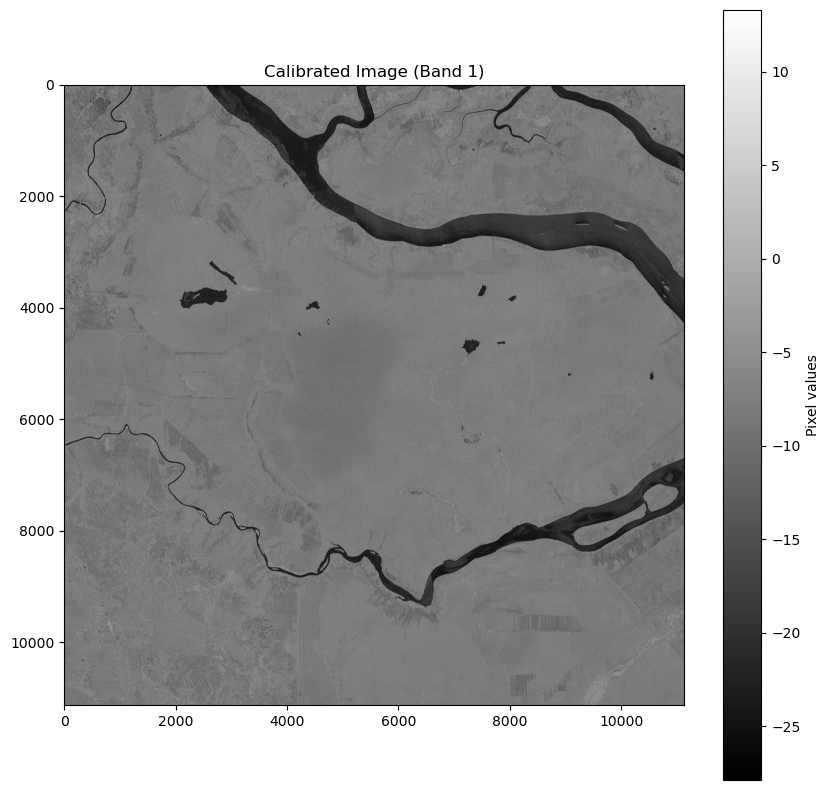

In [4]:
# Visualization
plt.figure(figsize=(10, 10))
plt.imshow(calibrated_image, cmap='gray')
plt.title('Calibrated Image (Band 1)')
plt.colorbar(label='Pixel values')
plt.show()

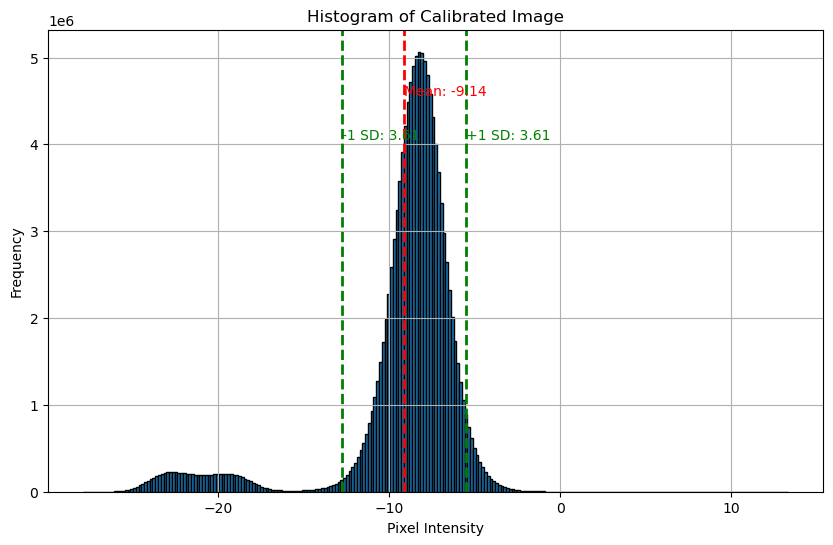

In [5]:
# Compute the histogram for the Filtered image
hist, bin_edges = np.histogram(calibrated_image, bins=255)
mean_val = np.mean(calibrated_image)
var_val = np.var(calibrated_image)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge')

# Annotate the mean and variance on the plot
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_val, max(hist) * 0.9, f'Mean: {mean_val:.2f}', color='red')

plt.axvline(mean_val + np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.axvline(mean_val - np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.text(mean_val + np.sqrt(var_val), max(hist) * 0.8, f'+1 SD: {np.sqrt(var_val):.2f}', color='green')
plt.text(mean_val - np.sqrt(var_val), max(hist) * 0.8, f'-1 SD: {np.sqrt(var_val):.2f}', color='green')

# Add titles and labels
plt.title('Histogram of Calibrated Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

**2. Apply Otsu's Thresholding**

Otsu's method calculates an optimal threshold value that minimizes intra-class variance between two classes (water and non-water).

In [6]:
# --- Otsu's and masking ---
from skimage.filters import threshold_otsu

threshold = threshold_otsu(calibrated_image)
print(f"Otsu's Threshold for SAR Image: {threshold}")

Otsu's Threshold for SAR Image: -14.770624160766602


In [7]:
# Create the binary water mask
water_mask = calibrated_image < threshold

**3. Post-Process**

Apply filtering to refine the mask and reduce noise. A median filter is common for this purpose.

In [8]:
from scipy.ndimage import median_filter

# Apply median filter
filtered_mask = median_filter(water_mask, size=3) # Use size 3 for a 3x3 window

**4. Visualize the Results**

Visualize the original SAR image and the resulting water mask for verification.

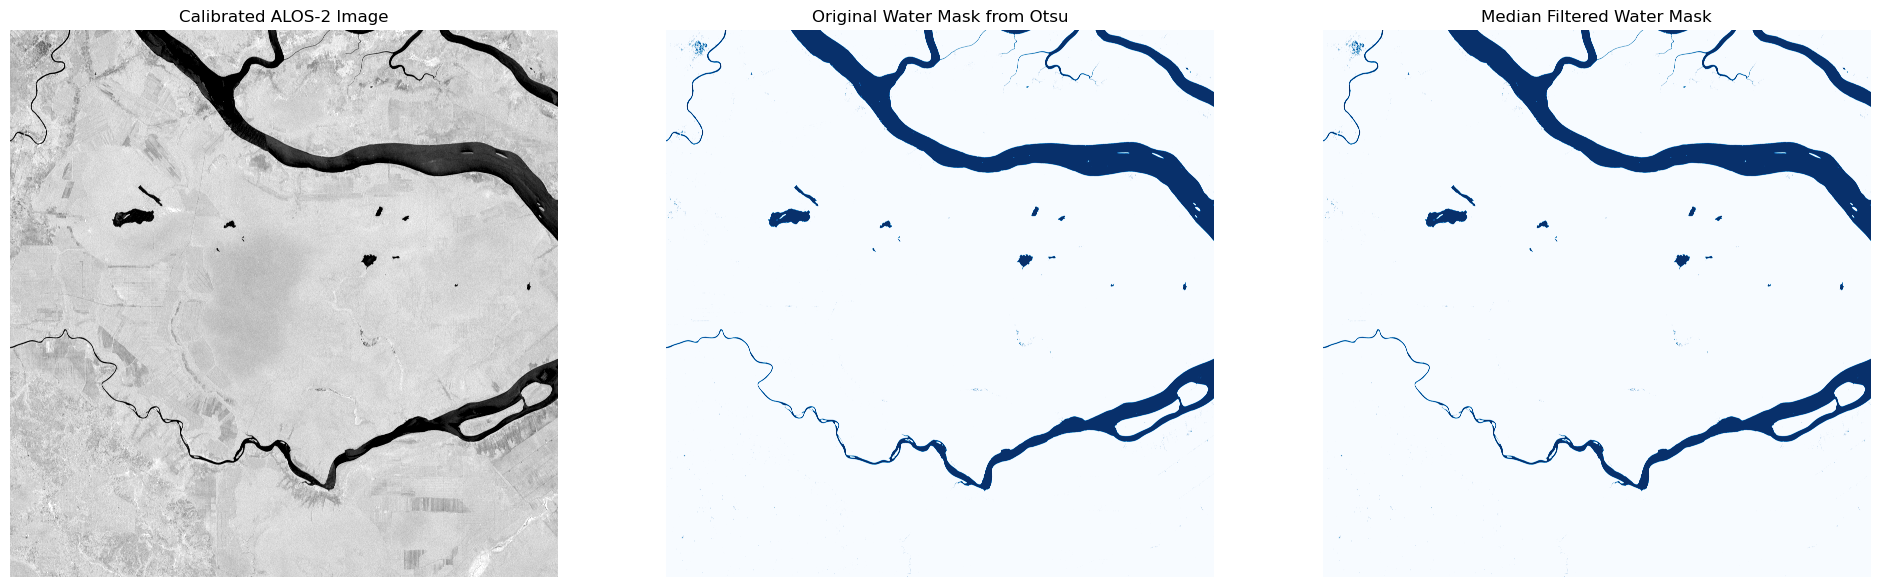

In [9]:
# Visualize the calibrated image, water mask, and median-filtered mask
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Display filtered ALOS-2 image
vmin = np.percentile(calibrated_image, 2)
vmax = np.percentile(calibrated_image, 98)
ax1.imshow(calibrated_image, cmap='gray', vmin=vmin, vmax=vmax)
ax1.set_title('Calibrated ALOS-2 Image')
ax1.axis('off')

# Display the original water mask
ax2.imshow(water_mask, cmap='Blues')
ax2.set_title('Original Water Mask from Otsu')
ax2.axis('off')

# Display the median-filtered water mask
ax3.imshow(filtered_mask, cmap='Blues')
ax3.set_title('Median Filtered Water Mask')
ax3.axis('off')


plt.show()

**5. Save the output**

In [10]:
# Define the output path for the water mask GeoTIFF
output_path = '/home/jovyan/shared/Arissara/genAI/water_mask-Indonesia.tif'

# Update the profile for the output file
output_profile = profile.copy()
output_profile.update({
    'dtype': 'float32',  # Ensure the output data type is Float32
    'count': 1,          # Single band for the mask
    'compress': 'lzw'    # Optional: Use LZW compression to reduce file size
})

# Save the water mask as a GeoTIFF
with rasterio.open(output_path, 'w', **output_profile) as dst:
    # Convert the filtered mask to Float32 before writing
    dst.write(filtered_mask.astype('float32'), 1)

print(f"Water mask exported successfully to {output_path}")


Water mask exported successfully to /home/jovyan/shared/Arissara/genAI/water_mask-Indonesia.tif
